In [66]:
from Utils_BLAST import *
from os import listdir
import matplotlib.pyplot as plt
from Utils_MSA import *

def extract_loci(S):
    s = S.split('_')
    return s[0]+'_'+s[1]

def Compile_BLAST_Hits(data_dir, cov = 90, divergence_filter = 15.0):
    df_out = pd.DataFrame()
    samples = listdir(data_dir)
    for s in samples:
        if s.startswith('MS'):
            loci = listdir(data_dir+s+'/')
            for l in loci:
                if l.endswith('_BLAST_Hits_Sample_Wise.pkl'):
                    df = pd.read_pickle(data_dir+s+'/'+l)
                    df['Loci'] = l.replace('_BLAST_Hits_Sample_Wise.pkl','')
                    df_out = df_out.append(df.reset_index(), ignore_index = True)   
                    
    del df_out['index']
    df_out = df_out[(df_out['Cov'] == cov) & (df_out['Divergence'] <= divergence_filter)]
    df_sample_wise = Summarize(df_out, ['Sample','Type'], ['Sample','Type'])    
    df_gene_wise = Summarize(df_out, ['Sample','Loci','Type'], ['Sample','Loci','Type']) 
   
    return df_sample_wise, df_gene_wise
    
rcParams = {'font.size': 12, 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal','axes.labelsize':10}
plt.rcParams.update(rcParams)

In [67]:
data_dir = '/Users/harihara/Mount-2/hotspring_metagenome/single_cell_analysis_with_Gabe_Birzu/\
C_Allele_Relative_Abundance_'
df_len = pd.read_csv('/Users/harihara/Mount-2/hotspring_metagenome/single_cell_analysis_with_Gabe_Birzu/\
C_Allele_Relative_Abundance_Aug/all_allele_len.txt', sep = "\t", names = ['Gene','Length'])

df_sample_100, df_gene_100 = Compile_BLAST_Hits(data_dir+'Apr_2023/BLAST_Hits/BLAST_Hits_E_1e3/Summary/')
df_sample_30, df_gene_30 = Compile_BLAST_Hits(data_dir+'Sep/BLAST_Comparison/BLAST_Hits/Summary/')

In [5]:
fasta_dir = '/Users/harihara/Mount-2/hotspring_metagenome/single_cell_analysis_with_Gabe_Birzu/alignments/'
samples = listdir(fasta_dir)
d = {}
A_Alleles, B_Alleles, C_Alleles = [], [], []

for l in samples:
    seqs = Load_Fasta_Seqs(fasta_dir+l, MSA_Encoding=True)
    d.update(seqs)    
    
top_30_alleles = {'A':dict({}),'B':dict({}),'C':dict({})}

top_30_alleles_dir = data_dir+'Sep/BLAST_Comparison/BLAST_Hits/'
for a in ['A','B','C']:
    seqs = listdir(top_30_alleles_dir+a+'_Alleles')
    for s in seqs:
        if s.startswith("."):
            continue
        s = s.replace(a+"_allele1","").replace(a+"_allele","").replace(a+"p_allele","")
        T = s.split('_')
        top_30_alleles[a][T[0]+'_'+T[1]] = "_".join(T[3:])[:-1]
        
d_PW = {}
strains = ['A', 'B', 'C']
window = 150
for i in range(len(strains)):
    for j in range(i+1, len(strains)):
        dist = []
        keys = top_30_alleles[strains[i]]
        for k in keys:
            S1 = d[top_30_alleles[strains[i]][k]]
            S2 = d[top_30_alleles[strains[j]][k]]
            for l in range(0, min(len(S1), len(S2))-window):
                distance = Compute_Pairwise_Distances(S1[l:l+window], S2[l:l+window], normalized=False)
                dist.append(distance)
        d_PW[strains[i]+strains[j]]=dist

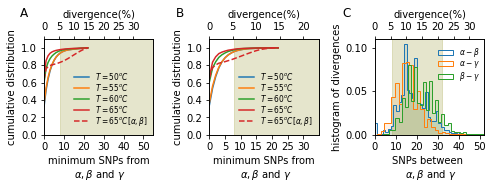

In [6]:
outpath = '/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/Single_Cell_Analyses/'
fig, ax = plt.subplots(1,3, figsize = (7.01,3.43*0.8))

color = ['C0','C1','C2','C3']
samples = ['MS50','MS55','MS60', 'MS65']
legends = [r'$T=50^oC$',r'$T=55^oC$',r'$T=60^oC$',r'$T=65^oC$']

ax20 = ax[0].twiny()
for i in range(len(samples)):
    s = samples[i]
    c = color[i]
    label_1 = legends[i] #+ r' [$\alpha, \beta, \gamma$]'
    df_sample_100.loc[(s,'ABC')].plot('mismatch', 'Normalized_Counts', linewidth = 1.5, label = label_1, 
                                       color = c, ax = ax[0])
    if samples[i] == 'MS65':
        df_sample_100.loc[(s,'AB')].plot('mismatch', 'Normalized_Counts', linestyle = '--',linewidth = 1.5,
                                          label = legends[i] + r'[$\alpha, \beta$]', color = c, ax = ax[0])

ax[0].set_xlabel('minimum SNPs from\n'+r' $\alpha, \beta $ and $\gamma$', size = 10)
ax20.set_xlabel('divergence(%)', size = 10)
xticks = range(0, 55, 10)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks, size = '10')
ax[0].set_ylabel('cumulative distribution', size = 10)

ax20.set_xlim(ax[0].get_xlim()[0]/150*100, ax[0].get_xlim()[1]/150*100)
sec_xticks = np.arange(0, 35, 5)
ax20.set_xticks(sec_xticks)
ax20.set_xticklabels(sec_xticks, size = '10')

ax[0].tick_params(axis='y', labelsize=10)
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax[0].set_ylim([0,1.1])
ax[0].set_xlim([0, 55])
ax[0].axvspan(8, ax[0].get_xlim()[1], color = 'olive', alpha = 0.2)
ax[0].legend(ncol = 1, loc = 4, frameon = False, fontsize = 7.5, labelspacing=0.01, columnspacing = 0.024,
         bbox_to_anchor=(1.01,0.0001))
ax20.set_xlim(ax[0].get_xlim()[0]/150*100, ax[0].get_xlim()[1]/150*100)
##################################################################################################################
ax21 = ax[1].twiny()
for i in range(len(samples)):
    s = samples[i]
    c = color[i]
    label_1 = legends[i] #+ r' [$\alpha, \beta, \gamma$]'
    df_sample_30.loc[(s,'ABC')].plot('mismatch', 'Normalized_Counts', linewidth = 1.5, label = label_1, 
                                       color = c, ax = ax[1])
    if samples[i] == 'MS65':
        df_sample_30.loc[(s,'AB')].plot('mismatch', 'Normalized_Counts', linestyle = '--',linewidth = 1.5,
                                          label = legends[i] + r'[$\alpha, \beta$]', color = c, ax = ax[1])

ax[1].set_xlabel('minimum SNPs from\n'+r' $\alpha, \beta $ and $\gamma$', size = 10)
ax21.set_xlabel('divergence(%)', size = 10)
xticks = range(0, 35, 5)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticks, size = '10')
ax[1].set_ylabel('cumulative distribution', size = 10)

ax21.set_xlim(ax[1].get_xlim()[0]/150*100, ax[1].get_xlim()[1]/150*100)
sec_xticks = np.arange(0, 25, 5)
ax21.set_xticks(sec_xticks)
ax21.set_xticklabels(sec_xticks, size = '10')

ax[1].tick_params(axis='y', labelsize=10)
ax[1].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax[1].set_ylim([0,1.1])
ax[1].set_xlim([0, 35])
ax[1].axvspan(8, ax[1].get_xlim()[1], color = 'olive', alpha = 0.2)
ax[1].legend(ncol = 1, loc = 4, frameon = False, fontsize = 7.5, labelspacing=0.01, columnspacing = 0.024,
         bbox_to_anchor=(1.01,0.0001))
ax21.set_xlim(ax[1].get_xlim()[0]/150*100, ax[1].get_xlim()[1]/150*100)
##################################################################################################################
ax22 = ax[2].twiny()
ax[2].hist(d_PW['AB'], bins = 35, histtype = 'step', color = 'C0', label = r'$\alpha-\beta$', density = True)
ax[2].hist(d_PW['AB'], bins = 35, color = 'C0', histtype = 'stepfilled',density = True, alpha = 0.1)

ax[2].hist(d_PW['AC'], bins = 35, histtype = 'step', color = 'C1', label = r'$\alpha-\gamma$', density = True)
ax[2].hist(d_PW['AC'], bins = 35, color = 'C1', histtype = 'stepfilled', alpha = 0.1, density = True)

ax[2].hist(d_PW['BC'], bins = 35, histtype = 'step', color = 'C2', label = r'$\beta-\gamma$', density = True)
ax[2].hist(d_PW['BC'], bins = 35, color = 'C2', histtype = 'stepfilled', alpha = 0.1, density = True)

ax[2].set_xlim([0, 65])
ax[2].axvspan(np.percentile(d_PW['AB']+d_PW['AC']+d_PW['BC'], 5), 
              np.percentile(d_PW['AB']+d_PW['AC']+d_PW['BC'],95), color = 'olive', alpha = 0.2)
ax[2].set_xlabel('SNPs between \n'+r' $\alpha, \beta $ and $\gamma$', size = 10)
ax[2].set_ylabel('histogram of divergences', size = 10)
ax[2].legend(ncol = 1, loc = 1, frameon = False, fontsize = 7.5, bbox_to_anchor=(1.025,1),
             labelspacing=0.01, columnspacing = 0.024)

xticks = range(0, 55, 10)
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xticks, size = '10')
ax[2].set_xlim([0, 52])
ax[2].tick_params(axis='y', labelsize=10)

sec_xticks = np.arange(0, 35, 5)
ax22.set_xlim(ax[2].get_xlim()[0]/150*100, ax[2].get_xlim()[1]/150*100)
ax22.set_xticks(sec_xticks)
ax22.set_xticklabels(sec_xticks, size = 10)
ax22.set_xlabel('divergence(%)', size = 10)

fig.text(0.05,0.9,'A', size = 12)
fig.text(0.36,0.9,'B', size = 12)
fig.text(0.69,0.9,'C', size = 12)

fig.tight_layout()

fig.savefig(outpath+'Fig-S10.pdf')

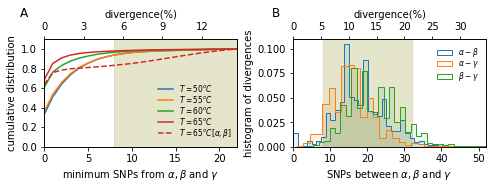

In [12]:
fig, ax = plt.subplots(1,2, figsize = (7.01,3.43*0.8))

color = ['C0','C1','C2','C3']
samples = ['MS50','MS55','MS60', 'MS65']
legends = [r'$T=50^oC$',r'$T=55^oC$',r'$T=60^oC$',r'$T=65^oC$']

ax20 = ax[0].twiny()
for i in range(len(samples)):
    s = samples[i]
    c = color[i]
    label_1 = legends[i] #+ r' [$\alpha, \beta, \gamma$]'
    df_sample_100.loc[(s,'ABC')].plot('mismatch', 'Normalized_Counts', linewidth = 1.5, label = label_1, 
                                       color = c, ax = ax[0])
    if samples[i] == 'MS65':
        df_sample_100.loc[(s,'AB')].plot('mismatch', 'Normalized_Counts', linestyle = '--',linewidth = 1.5,
                                          label = legends[i] + r'[$\alpha, \beta$]', color = c, ax = ax[0])

ax[0].set_xlabel('minimum SNPs from'+r' $\alpha, \beta $ and $\gamma$', size = 10)
ax20.set_xlabel('divergence(%)', size = 10)
xticks = range(0, 35, 5)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks, size = '10')
ax[0].set_ylabel('cumulative distribution', size = 10)

ax20.set_xlim(ax[0].get_xlim()[0]/150*100, ax[0].get_xlim()[1]/150*100)
sec_xticks = np.arange(0, 15, 3)
ax20.set_xticks(sec_xticks)
ax20.set_xticklabels(sec_xticks, size = '10')

ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax[0].tick_params(axis='y', labelsize=10)
ax[0].set_ylim([0,1.1])
ax[0].set_xlim([0, 22])
ax[0].axvspan(8, ax[0].get_xlim()[1], color = 'olive', alpha = 0.2)
ax[0].legend(ncol = 1, loc = 4, frameon = False, fontsize = 7.5, labelspacing=0.01, columnspacing = 0.024,
         bbox_to_anchor=(1.01,0.0001))
ax20.set_xlim(ax[0].get_xlim()[0]/150*100, ax[0].get_xlim()[1]/150*100)
##################################################################################################################

ax21 = ax[1].twiny()
ax[1].hist(d_PW['AB'], bins = 35, histtype = 'step', color = 'C0', label = r'$\alpha-\beta$', density = True)
ax[1].hist(d_PW['AB'], bins = 35, color = 'C0', histtype = 'stepfilled',density = True, alpha = 0.1)

ax[1].hist(d_PW['AC'], bins = 35, histtype = 'step', color = 'C1', label = r'$\alpha-\gamma$', density = True)
ax[1].hist(d_PW['AC'], bins = 35, color = 'C1', histtype = 'stepfilled', alpha = 0.1, density = True)

ax[1].hist(d_PW['BC'], bins = 35, histtype = 'step', color = 'C2', label = r'$\beta-\gamma$', density = True)
ax[1].hist(d_PW['BC'], bins = 35, color = 'C2', histtype = 'stepfilled', alpha = 0.1, density = True)

ax[1].set_xlim([0, 65])
ax[1].axvspan(np.percentile(d_PW['AB']+d_PW['AC']+d_PW['BC'], 5), 
              np.percentile(d_PW['AB']+d_PW['AC']+d_PW['BC'],95), color = 'olive', alpha = 0.2)
ax[1].set_xlabel('SNPs between'+r' $\alpha, \beta $ and $\gamma$', size = 10)
ax[1].set_ylabel('histogram of divergences', size = 10)
ax[1].legend(ncol = 1, loc = 1, frameon = False, fontsize = 7.5, bbox_to_anchor=(1,1),
             labelspacing=0.01, columnspacing = 0.024)

xticks = range(0, 55, 10)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticks, size = '10')
ax[1].set_xlim([0, 52])
ax[1].tick_params(axis='y', labelsize=10)

sec_xticks = np.arange(0, 35, 5)
ax21.set_xlim(ax[1].get_xlim()[0]/150*100, ax[1].get_xlim()[1]/150*100)
ax21.set_xticks(sec_xticks)
ax21.set_xticklabels(sec_xticks, size = 10)
ax21.set_xlabel('divergence(%)', size = 10)

fig.text(0.05,0.9,'A', size = 12)
fig.text(0.55,0.9,'B', size = 12)

fig.tight_layout()

fig.savefig(outpath+'Fig-S10.pdf')

In [28]:
T = df_sample_100[(df_sample_100['mismatch'] <= 8)].reset_index()
B = T[(T['Type'] == 'AB') & (T['Sample'] == 'MS65')].iloc[-1]['Counts']
A = T[(T['Type'] == 'ABC') & (T['Sample'] == 'MS65')].iloc[-1]['Counts']
print((A-B)/A*100.0)

18.20373107285894


In [29]:
A = T[T['Type'] == 'ABC']['qseqid'].sum()
T = df_sample_100.reset_index()
B = T[T['Type'] == 'ABC']['qseqid'].sum()
print(100 - A/B*100)

3.663745729353934

In [55]:
df_abund = df_gene_100[(df_gene_100['mismatch'] <= 8)].reset_index()
df_abund = df_abund[df_abund['Type'] == 'ABC']
df_abund = df_abund.groupby('Loci').sum()[['qseqid']]
df_len['Loci'] = df_len['Gene'].apply(extract_loci)
df_len = df_len.groupby('Loci').max()
df_depth = df_abund.join(df_len[['Length']])
df_depth['Depth'] = df_depth['qseqid']*150/df_depth['Length']
print(df_depth['Depth'].mean(), df_depth['qseqid'].sum())

      Sample        Loci Type  mismatch  Divergence  qseqid  Counts  \
9       MS50  YSG_0023aa  ABC         0    0.000000    1352    1352   
10      MS50  YSG_0023aa  ABC         1    0.666667     412    1764   
11      MS50  YSG_0023aa  ABC         2    1.333333     484    2248   
12      MS50  YSG_0023aa  ABC         3    2.000000     424    2672   
13      MS50  YSG_0023aa  ABC         4    2.666667     205    2877   
...      ...         ...  ...       ...         ...     ...     ...   
14373   MS65    YSG_2188  ABC         4    2.666667     432   30434   
14374   MS65    YSG_2188  ABC         5    3.333333     251   30685   
14375   MS65    YSG_2188  ABC         6    4.000000     122   30807   
14376   MS65    YSG_2188  ABC         7    4.666667      94   30901   
14377   MS65    YSG_2188  ABC         8    5.333333      57   30958   

       Normalized_Counts  Rev_Cumulative  
9               0.379882        0.620118  
10              0.495645        0.504355  
11              0.